In [1]:
#| default_exp models.informer

# Informer

**References**<br>
- [Haoyi Zhou, Shanghang Zhang, Jieqi Peng, Shuai Zhang, Jianxin Li, Hui Xiong, Wancai Zhang. "Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting"](https://arxiv.org/abs/2012.07436)<br>

![Figure 1. Temporal Fusion Transformer Architecture.](imgs_models/informer_architecture.png)

In [2]:
#| export
import math
import numpy as np
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

from neuralforecast.common._modules import (
    TransEncoderLayer, TransEncoder,
    TransDecoderLayer, TransDecoder,
    DataEmbedding, AttentionLayer,
)
from neuralforecast.common._base_windows import BaseWindows

from neuralforecast.losses.pytorch import MAE

/opt/anaconda3/envs/neuralforecast/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

## 1. Auxiliary Functions

In [4]:
#| export
class ConvLayer(nn.Module):
    def __init__(self, c_in):
        super(ConvLayer, self).__init__()
        self.downConv = nn.Conv1d(in_channels=c_in,
                                  out_channels=c_in,
                                  kernel_size=3,
                                  padding=2,
                                  padding_mode='circular')
        self.norm = nn.BatchNorm1d(c_in)
        self.activation = nn.ELU()
        self.maxPool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.downConv(x.permute(0, 2, 1))
        x = self.norm(x)
        x = self.activation(x)
        x = self.maxPool(x)
        x = x.transpose(1, 2)
        return x

In [5]:
#| export
class ProbMask():
    def __init__(self, B, H, L, index, scores, device="cpu"):
        _mask = torch.ones(L, scores.shape[-1], dtype=torch.bool).to(device).triu(1)
        _mask_ex = _mask[None, None, :].expand(B, H, L, scores.shape[-1])
        indicator = _mask_ex[torch.arange(B)[:, None, None],
                    torch.arange(H)[None, :, None],
                    index, :].to(device)
        self._mask = indicator.view(scores.shape).to(device)

    @property
    def mask(self):
        return self._mask


class ProbAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(ProbAttention, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def _prob_QK(self, Q, K, sample_k, n_top):  # n_top: c*ln(L_q)
        # Q [B, H, L, D]
        B, H, L_K, E = K.shape
        _, _, L_Q, _ = Q.shape

        # calculate the sampled Q_K
        K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)

        index_sample = torch.randint(L_K, (L_Q, sample_k))  # real U = U_part(factor*ln(L_k))*L_q
        K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :]
        Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze()

        # find the Top_k query with sparisty measurement
        M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)
        M_top = M.topk(n_top, sorted=False)[1]

        # use the reduced Q to calculate Q_K
        Q_reduce = Q[torch.arange(B)[:, None, None],
                   torch.arange(H)[None, :, None],
                   M_top, :]  # factor*ln(L_q)
        Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1))  # factor*ln(L_q)*L_k

        return Q_K, M_top

    def _get_initial_context(self, V, L_Q):
        B, H, L_V, D = V.shape
        if not self.mask_flag:
            # V_sum = V.sum(dim=-2)
            V_sum = V.mean(dim=-2)
            contex = V_sum.unsqueeze(-2).expand(B, H, L_Q, V_sum.shape[-1]).clone()
        else:  # use mask
            assert (L_Q == L_V)  # requires that L_Q == L_V, i.e. for self-attention only
            contex = V.cumsum(dim=-2)
        return contex

    def _update_context(self, context_in, V, scores, index, L_Q, attn_mask):
        B, H, L_V, D = V.shape

        if self.mask_flag:
            attn_mask = ProbMask(B, H, L_Q, index, scores, device=V.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)

        attn = torch.softmax(scores, dim=-1)  # nn.Softmax(dim=-1)(scores)

        context_in[torch.arange(B)[:, None, None],
        torch.arange(H)[None, :, None],
        index, :] = torch.matmul(attn, V).type_as(context_in)
        if self.output_attention:
            attns = (torch.ones([B, H, L_V, L_V]) / L_V).type_as(attn).to(attn.device)
            attns[torch.arange(B)[:, None, None], torch.arange(H)[None, :, None], index, :] = attn
            return (context_in, attns)
        else:
            return (context_in, None)

    def forward(self, queries, keys, values, attn_mask):
        B, L_Q, H, D = queries.shape
        _, L_K, _, _ = keys.shape

        queries = queries.transpose(2, 1)
        keys = keys.transpose(2, 1)
        values = values.transpose(2, 1)

        U_part = self.factor * np.ceil(np.log(L_K)).astype('int').item()  # c*ln(L_k)
        u = self.factor * np.ceil(np.log(L_Q)).astype('int').item()  # c*ln(L_q)

        U_part = U_part if U_part < L_K else L_K
        u = u if u < L_Q else L_Q

        scores_top, index = self._prob_QK(queries, keys, sample_k=U_part, n_top=u)

        # add scale factor
        scale = self.scale or 1. / math.sqrt(D)
        if scale is not None:
            scores_top = scores_top * scale
        # get the context
        context = self._get_initial_context(values, L_Q)
        # update the context with selected top_k queries
        context, attn = self._update_context(context, values, scores_top, index, L_Q, attn_mask)

        return context.contiguous(), attn

## 2. Informer

In [6]:
#| export
# TODO: homogeneize arguments with TFT
# TODO: Define reasonable model dimensions
# TODO: Deprecate freq
# TODO: Correct instantiation of Linear within TemporalPositionalEmbed
# TODO: Add hist_exog, stat_exog into model inputs
# TODO: Tutorial para informer, mencionando diferencias: 
# (1) univariate, (2) exogenous vs calendar temporal position embedding, 
# (3) admite exógenas, (4) probabilistic outputs
class Informer(BaseWindows):
    def __init__(self,
                 h: int, 
                 input_size: int,
                 freq: str,
                 stat_exog_list = None,
                 hist_exog_list = None,
                 futr_exog_list = None,
                 # Architecture ------------------------------------------------
                 # TODO: homogeneize with TFT
                 # TODO: Define reasonable model dimensions
                 label_len_multiplier: float = 0.5,
                 d_model: int = 512, 
                 embed_type: str = 'timeF',
                 dropout: float = 0.05,
                 factor: int = 5,
                 n_heads: int = 8,
                 d_ff: int = 2048,
                 activation: str = 'gelu',
                 e_layers: int = 2, 
                 d_layers: int = 1, 
                 distil: bool = True,
                 # Optimization ------------------------------------------------
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 5000,
                 learning_rate: float = 1e-4,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 **trainer_kwargs):
        super(Informer, self).__init__(h=h,
                                       input_size=input_size,
                                       hist_exog_list=hist_exog_list,
                                       stat_exog_list=stat_exog_list,
                                       futr_exog_list = futr_exog_list,
                                       loss=loss,
                                       valid_loss=valid_loss,
                                       max_steps=max_steps,
                                       learning_rate=learning_rate,
                                       num_lr_decays=num_lr_decays,
                                       early_stop_patience_steps=early_stop_patience_steps,
                                       val_check_steps=val_check_steps,
                                       batch_size=batch_size,
                                       windows_batch_size=windows_batch_size,
                                       valid_batch_size=valid_batch_size,
                                       step_size=step_size,
                                       scaler_type=scaler_type,
                                       num_workers_loader=num_workers_loader,
                                       drop_last_loader=drop_last_loader,
                                       random_seed=random_seed,
                                       **trainer_kwargs)

        # Architecture
        self.futr_input_size = len(self.futr_exog_list)
        self.hist_input_size = len(self.hist_exog_list)
        self.stat_input_size = len(self.stat_exog_list)

        self.label_len = int(np.ceil(input_size * label_len_multiplier))
        if (self.label_len >= input_size) or (self.label_len <= 0):
            raise Exception(f'Check label_len_multiplier={label_len_multiplier}, range (0,1)')

        if embed_type not in ['timeF', 'fixed', 'learned']:
            raise Exception(f'Check embed_type={embed_type}')

        if activation not in ['relu', 'gelu']:
            raise Exception(f'Check activation={activation}')
        
        # TODO: Deprecate freq
        # TODO: Correct instantiation of Linear within TemporalPositionalEmbed
        if freq not in ['h', 't', 's', 'm', 'a', 'w', 'd', 'b']:
            raise Exception(f'Check freq={freq}')

        self.c_out = self.loss.outputsize_multiplier
        self.output_attention = False
        self.enc_in = 1 
        self.dec_in = 1

        # Embedding
        self.enc_embedding = DataEmbedding(c_in=self.enc_in, 
                                           d_model=d_model, 
                                           embed_type=embed_type, 
                                           freq=freq,
                                           dropout=dropout)
        self.dec_embedding = DataEmbedding(self.dec_in,
                                           d_model=d_model,
                                           embed_type=embed_type,
                                           freq=freq,
                                           dropout=dropout)

        # Encoder
        self.encoder = TransEncoder(
            [
                TransEncoderLayer(
                    AttentionLayer(
                        ProbAttention(False, factor, 
                                      attention_dropout=dropout,
                                      output_attention=self.output_attention),
                        d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers)
            ],
            [
                ConvLayer(
                    d_model
                ) for l in range(e_layers - 1)
            ] if distil else None,
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # Decoder
        self.decoder = TransDecoder(
            [
                TransDecoderLayer(
                    AttentionLayer(
                        ProbAttention(True, factor, attention_dropout=dropout, output_attention=False),
                        d_model, n_heads),
                    AttentionLayer(
                        ProbAttention(False, factor, attention_dropout=dropout, output_attention=False),
                        d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation,
                )
                for l in range(d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model),
            projection=nn.Linear(d_model, self.c_out, bias=True)
        )

    def forward(self, windows_batch):
        # TODO: Add hist_exog, stat_exog into model

        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        #insample_mask = windows_batch['insample_mask']
        futr_exog     = windows_batch['futr_exog']
        #hist_exog     = windows_batch['hist_exog']
        #stat_exog     = windows_batch['stat_exog']

        insample_y = insample_y.unsqueeze(-1) # [Ws,L,1]
        x_mark_enc = futr_exog[:,:self.input_size,:]
        x_mark_dec = futr_exog[:,-(self.label_len+self.h):,:]
        
        x_dec = torch.zeros(size=(len(insample_y),self.h,1))
        x_dec = torch.cat([insample_y[:,-self.label_len:,:], x_dec], dim=1)        

        enc_out = self.enc_embedding(insample_y, x_mark_enc)
        enc_out, _ = self.encoder(enc_out, attn_mask=None) # attns visualization
        
        dec_out = self.dec_embedding(x_dec, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=None, 
                               cross_mask=None)

        forecast = self.loss.domain_map(dec_out[:, -self.h:])
        return forecast

In [7]:
show_doc(Informer)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/informer.py#L169){target="_blank" style="float:right; font-size:smaller"}

### Informer

>      Informer (h:int, input_size:int, freq:str, stat_exog_list=None,
>                hist_exog_list=None, futr_exog_list=None,
>                label_len_multiplier:float=0.5, d_model:int=512,
>                embed_type:str='timeF', dropout:float=0.05, factor:int=5,
>                n_heads:int=8, d_ff:int=2048, activation:str='gelu',
>                e_layers:int=2, d_layers:int=1, distil:bool=True, loss=MAE(),
>                valid_loss=None, max_steps:int=5000,
>                learning_rate:float=0.0001, num_lr_decays:int=-1,
>                early_stop_patience_steps:int=-1, val_check_steps:int=100,
>                batch_size:int=32, valid_batch_size:Optional[int]=None,
>                windows_batch_size=1024, step_size:int=1,
>                scaler_type:str='identity', random_seed:int=1,
>                num_workers_loader:int=0, drop_last_loader:bool=False,
>                **trainer_kwargs)

Hooks to be used in LightningModule.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| h | int |  |  |
| input_size | int |  |  |
| freq | str |  |  |
| stat_exog_list | NoneType | None |  |
| hist_exog_list | NoneType | None |  |
| futr_exog_list | NoneType | None |  |
| label_len_multiplier | float | 0.5 | Architecture ------------------------------------------------<br>TODO: homogeneize with TFT<br>TODO: Define reasonable model dimensions |
| d_model | int | 512 |  |
| embed_type | str | timeF |  |
| dropout | float | 0.05 |  |
| factor | int | 5 |  |
| n_heads | int | 8 |  |
| d_ff | int | 2048 |  |
| activation | str | gelu |  |
| e_layers | int | 2 |  |
| d_layers | int | 1 |  |
| distil | bool | True |  |
| loss | MAE | MAE() | Optimization ------------------------------------------------ |
| valid_loss | NoneType | None |  |
| max_steps | int | 5000 |  |
| learning_rate | float | 0.0001 |  |
| num_lr_decays | int | -1 |  |
| early_stop_patience_steps | int | -1 |  |
| val_check_steps | int | 100 |  |
| batch_size | int | 32 |  |
| valid_batch_size | Optional | None |  |
| windows_batch_size | int | 1024 |  |
| step_size | int | 1 |  |
| scaler_type | str | identity |  |
| random_seed | int | 1 |  |
| num_workers_loader | int | 0 |  |
| drop_last_loader | bool | False |  |
| trainer_kwargs |  |  |  |

In [8]:
show_doc(Informer.fit, name='Informer.fit')

---

### Informer.fit

>      Informer.fit (dataset, val_size=0, test_size=0)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [9]:
show_doc(Informer.predict, name='Informer.predict')

---

### Informer.predict

>      Informer.predict (dataset, test_size=None, step_size=1,
>                        **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

## Usage Example

In [10]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

AirPassengersPanel['c1'] = 1
AirPassengersPanel['c2'] = 1
AirPassengersPanel['c3'] = 1
AirPassengersPanel['c4'] = 1

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.59it/s]


[]

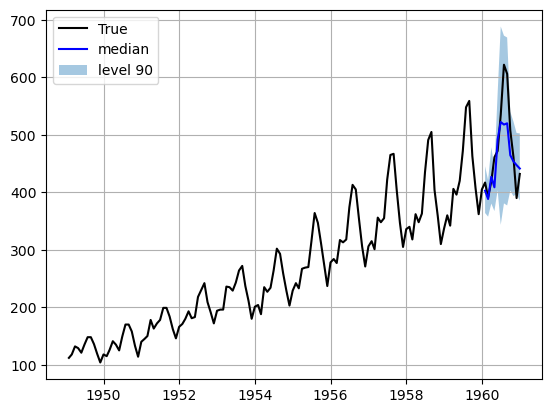

In [11]:
model = Informer(h=12, input_size=24,
                 d_model = 16,
                 d_ff = 32,
                 n_heads = 2,
                 loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
                 #loss=MAE(),
                 freq='h',
                 futr_exog_list=['c1','c2','c3','c4'],
                 scaler_type='robust',
                 learning_rate=1e-3,
                 max_steps=500,
                 val_check_steps=50,
                 early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='M'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = nf.predict(futr_df=Y_test_df)

Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['Informer-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['Informer-lo-90'][-12:].values, 
                 y2=plot_df['Informer-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.grid()
plt.legend()
plt.plot()

# plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
# plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
# plt.plot(plot_df['ds'], plot_df['Informer'], c='blue', label='Forecast')
# plt.legend()
# plt.grid()